In [1]:
import numpy as np
import pandas as pd 
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.ticker as ticker

In [15]:
##PATH ALGORITHM

def svm_path(X, T, Y, kernel, C):
    """
    Compute the SVM regularization path.
    :param X: Feature matrix (N, p)
    :param y: Target vector (N,)
    :param C_range: List of regularization parameters
    :return: List of SVM models and corresponding coefficients
    """
    models = []
    coefficients = []
    weights = []
    ate = []

    diff = []
    ess = []
    W = 2 * T - 1
    

    svm = SVC(kernel=kernel, C=C, probability=True)
    svm.fit(X, W)
    models.append(svm)
    weights = compute_svm_weights(X, svm)
    ate = estimate_ate(Y, T, weights)
    diff = estimate_diff(Y, W)
    ess = estimate_ess(W, weights)

    if kernel == 'linear':
        coefficients.append(svm.coef_.flatten())
    else:
        coefficients.append(np.abs(svm.dual_coef_[0]))
    

    # kernel_ate_estimates.append(ate)
    # C_values.append(model.C)

    return ate, diff, ess

##SVM DUAL
def compute_svm_weights(X, model):
    """
    计算 SVM 平衡权重
    :param X: 协变量矩阵 (N, p)
    :param T: 处理变量 (N,)
    :param kernel: 核函数类型 ('linear', 'poly', 'rbf')
    :param C: 正则化参数
    :return: 平衡权重 (N,)
    """
    
    # 获取对偶系数
    alpha = np.abs(model.dual_coef_[0])
    support_indices = model.support_
    
    # 计算权重
    weights = np.zeros(X.shape[0])
    weights[support_indices] = np.abs(alpha)
    weights = weights / np.sum(weights)

    return weights


##ATE ESTIMATION
def estimate_ate(Y, T, weights):
    """
    使用加权差异估计器估计 ATE
    :param Y: 结果变量 (N,)
    :param T: 处理变量 (N,)
    :param weights: 平衡权重 (N,)
    :return: ATE 估计值
    """
    treated_mean = np.sum(Y[T == 1] * weights[T == 1]) / np.sum(weights[T == 1])
    control_mean = np.sum(Y[T == 0] * weights[T == 0]) / np.sum(weights[T == 0])
    return treated_mean - control_mean


def estimate_diff(Y, W):
    
    treated_mean = np.mean(Y[W == 1])
    control_mean = np.mean(Y[W == -1])
    
    treated_std = np.std(Y[W == 1], ddof=1)
    control_std = np.std(Y[W == -1], ddof=1)

    normed_diff = np.abs(treated_mean - control_mean) / np.sqrt((treated_std**2 + control_std**2) / 2)

    return normed_diff


def estimate_ess(W, weights):
    
    treated_ess = (np.sum(weights[W == 1]))**2 / np.sum(weights[W == 1]**2)
    control_ess = (np.sum(weights[W == -1]))**2 / np.sum(weights[W == -1]**2)

    return treated_ess + control_ess

In [17]:
num_datasets = 100
simulation_results_A = {n: [] for n in range(num_datasets)}

# Define a range of regularization parameters
C_range = np.logspace(-3, 3, 10)
kernels = ['rbf']

for n in range(num_datasets):
    simulate_data_A = pd.read_csv('../data_A/data_scenario_G_n_500_dataset_{}.csv'.format(n))
    X = simulate_data_A.drop(columns=['T', 'Y'])
    T = simulate_data_A['T']
    Y = simulate_data_A['Y']
    
    
    results = {kernel: [] for kernel in kernels}
    for kernel in kernels:
        for C in C_range:
            path = svm_path(X, T, Y, kernel, C)

            results[kernel].append(path) 
    
    simulation_results_A[n] = results 

print(simulation_results_A)

{0: {'rbf': [(np.float64(-0.3931896427524543), np.float64(0.9664122844749827), np.float64(450.06182017339313)), (np.float64(-0.39440123065061056), np.float64(0.9664122844749827), np.float64(453.2253454220212)), (np.float64(-0.394512028290747), np.float64(0.9664122844749827), np.float64(453.25600119742626)), (np.float64(-0.39465110333484693), np.float64(0.9664122844749827), np.float64(453.4024570819046)), (np.float64(-0.3981063330325745), np.float64(0.9664122844749827), np.float64(445.61652432661896)), (np.float64(-0.4030556784955479), np.float64(0.9664122844749827), np.float64(403.55683042929525)), (np.float64(-0.4137427197188484), np.float64(0.9664122844749827), np.float64(332.9935122279801)), (np.float64(-0.4171437519511828), np.float64(0.9664122844749827), np.float64(244.5193431694512)), (np.float64(-0.42456204043016627), np.float64(0.9664122844749827), np.float64(152.04510825920693)), (np.float64(-0.4280474302891477), np.float64(0.9664122844749827), np.float64(128.30174098719647))]

In [18]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """自定义JSON编码器，用于处理numpy数据类型"""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyEncoder, self).default(obj)

# 假设simulation_results_A是一个包含numpy数据类型的列表或字典
data = simulation_results_A

# 使用自定义编码器将数据转换为JSON格式的字符串
data_str = json.dumps(data, cls=NumpyEncoder, indent=4)

# 保存到TXT文件
with open('simulation_results_A.json', 'w') as f:
    f.write(data_str)

In [4]:
num_datasets = 10
simulation_results_B = {n: [] for n in range(num_datasets)}

# Define a range of regularization parameters
C_range = np.logspace(-3, 3, 10)
kernels = ['poly', 'rbf']

for n in range(num_datasets):
    simulate_data_B = pd.read_csv('C:/Users/rmaat\Desktop/MSc/data_B/dataset_{}.csv'.format(n))
    X = simulate_data_B.drop(columns=['T', 'Y'])
    T = simulate_data_B['T']
    Y = simulate_data_B['Y']
    
    
    results = {kernel: [] for kernel in kernels}
    for kernel in kernels:
        results[kernel] = svm_path(X, T, Y, kernel, C_range)
    
    simulation_results_B[n] = results 

print(simulation_results_B)

{0: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(12.36171680589598), np.float64(11.915615238676224), np.float64(10.15765060948118), np.float64(8.11346346677945), np.float64(6.976779089333064), np.float64(7.46411496517581), np.float64(7.5918191642094826), np.float64(7.521773055000978), np.float64(7.470723544380036), np.float64(7.4572317271153)]), 'rbf

In [6]:
simulation_results_A = {0: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.36328034889699), np.float64(-0.36659989382573305), np.float64(-0.3673593350176248), np.float64(-0.36772934976097776), np.float64(-0.37229709353310153), np.float64(-0.3773286202157533), np.float64(-0.3797180747864394), np.float64(-0.3734696630641411), np.float64(-0.3792760750879012), np.float64(-0.3840559840594329)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.4110971836064154), np.float64(-0.4074453543932864), np.float64(-0.4062179225936626), np.float64(-0.4065350759384389), np.float64(-0.4064076923547263), np.float64(-0.4034297547886309), np.float64(-0.3983156233992679), np.float64(-0.3857133996637856), np.float64(-0.38863580013018895), np.float64(-0.3873722153124664)])}, 1: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.41001485521222686), np.float64(-0.4091385662407562), np.float64(-0.40941442156082436), np.float64(-0.4094575745562468), np.float64(-0.41280874786332367), np.float64(-0.4119743906411296), np.float64(-0.4160068211981558), np.float64(-0.4170529322053808), np.float64(-0.42075800804895014), np.float64(-0.4218834288334264)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.4044769079220035), np.float64(-0.4013510036952742), np.float64(-0.4019207424978854), np.float64(-0.40148757315619593), np.float64(-0.40153775377975864), np.float64(-0.40679296380707136), np.float64(-0.40724132248846756), np.float64(-0.40884979047368075), np.float64(-0.41851085987362374), np.float64(-0.41907440578955485)])}, 2: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.3928195541580643), np.float64(-0.3914820897685048), np.float64(-0.39161355750606713), np.float64(-0.39144584027582824), np.float64(-0.39038598552383785), np.float64(-0.383016024787885), np.float64(-0.38521258001383263), np.float64(-0.383743539443639), np.float64(-0.3896930485745529), np.float64(-0.39118727283979493)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.39799024215369544), np.float64(-0.3916757216600587), np.float64(-0.3901792182067578), np.float64(-0.39034979707323575), np.float64(-0.39026873312058297), np.float64(-0.4015807294952024), np.float64(-0.404563079622577), np.float64(-0.3997207131051841), np.float64(-0.3876370189204923), np.float64(-0.3875291147492451)])}, 3: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.3635059534020444), np.float64(-0.3642320805050991), np.float64(-0.3641139163746355), np.float64(-0.36421643444821944), np.float64(-0.3664572812871407), np.float64(-0.3769611112043301), np.float64(-0.3859409956469828), np.float64(-0.38687346714874504), np.float64(-0.3904232959442491), np.float64(-0.39805191651133465)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.39372042332498103), np.float64(-0.399325321512957), np.float64(-0.3987014952409264), np.float64(-0.3989118530684298), np.float64(-0.3991218395037116), np.float64(-0.39562281911628444), np.float64(-0.38925547726805115), np.float64(-0.38107832563952393), np.float64(-0.37690125863902124), np.float64(-0.37377367107111703)])}, 4: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.4157662184121567), np.float64(-0.41707778775974064), np.float64(-0.41724332890796295), np.float64(-0.4172801721999364), np.float64(-0.4107899721875177), np.float64(-0.4196202984952659), np.float64(-0.4229961095503062), np.float64(-0.4211962156912856), np.float64(-0.42354394666167056), np.float64(-0.4363210683930561)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.4013370261291142), np.float64(-0.39835079439700466), np.float64(-0.3977507849736284), np.float64(-0.39750753980470893), np.float64(-0.3975889598611425), np.float64(-0.3919901414917257), np.float64(-0.4080123198908698), np.float64(-0.40980417065516994), np.float64(-0.40890560569598083), np.float64(-0.40712807071503776)])}, 5: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.40559544825478266), np.float64(-0.40728077833931636), np.float64(-0.4074175497327884), np.float64(-0.40729112320672156), np.float64(-0.4026616202589966), np.float64(-0.40659375892931854), np.float64(-0.4084565431397414), np.float64(-0.40777605739484285), np.float64(-0.41039581317198237), np.float64(-0.4200539901086774)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.40655310410184686), np.float64(-0.40010015105969576), np.float64(-0.400513383494752), np.float64(-0.400146008300956), np.float64(-0.40007351312807315), np.float64(-0.4013960445702711), np.float64(-0.40509391382952675), np.float64(-0.4141818590992367), np.float64(-0.4280243604426105), np.float64(-0.42931988806783006)])}, 6: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.41148893845643053), np.float64(-0.41145872160969765), np.float64(-0.41138195660788907), np.float64(-0.4113939666836998), np.float64(-0.4052061431096118), np.float64(-0.39846592672101067), np.float64(-0.39524415848183675), np.float64(-0.3819447072049086), np.float64(-0.38319735333300364), np.float64(-0.3768827590403245)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.42319947521323625), np.float64(-0.4202716805514422), np.float64(-0.41944402940222797), np.float64(-0.4192899707502636), np.float64(-0.4193280539329692), np.float64(-0.42120926322898944), np.float64(-0.41491125296970677), np.float64(-0.4058489883461972), np.float64(-0.3875309738195297), np.float64(-0.38094104979974636)])}, 7: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.38086646645117844), np.float64(-0.3806048386739004), np.float64(-0.38028806011186456), np.float64(-0.3804629278716932), np.float64(-0.3801188594497096), np.float64(-0.38445868560214763), np.float64(-0.3811756431990021), np.float64(-0.3759112106692248), np.float64(-0.3798409979149067), np.float64(-0.39314158871455424)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.39290574747434415), np.float64(-0.3950420475517413), np.float64(-0.39408606003614965), np.float64(-0.3939218869225559), np.float64(-0.3939619588605997), np.float64(-0.39579973270598934), np.float64(-0.390872299453544), np.float64(-0.3748504586003975), np.float64(-0.37426956169063547), np.float64(-0.37426956169063547)])}, 8: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.42335508328283483), np.float64(-0.42264687567237114), np.float64(-0.42177415860800815), np.float64(-0.4214208292161981), np.float64(-0.42016610478830174), np.float64(-0.4147241019734343), np.float64(-0.4119024252402206), np.float64(-0.4135661259952882), np.float64(-0.40932521009337447), np.float64(-0.413868696647625)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.3953443601749348), np.float64(-0.3957808774115875), np.float64(-0.3962613441811758), np.float64(-0.3968000952518778), np.float64(-0.3968605186492843), np.float64(-0.3999442738219144), np.float64(-0.4078207104835533), np.float64(-0.40144087760276603), np.float64(-0.40670176457990526), np.float64(-0.40670176457990526)])}, 9: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(-0.40633207285880135), np.float64(-0.40622226483647766), np.float64(-0.4060043025976894), np.float64(-0.4091395438807283), np.float64(-0.4128997490168869), np.float64(-0.4107643655311583), np.float64(-0.41104699660771493), np.float64(-0.40544215376356746), np.float64(-0.4053389225401986), np.float64(-0.4096856870900074)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(-0.38567418146556), np.float64(-0.38660831721678257), np.float64(-0.3872980536642381), np.float64(-0.38713997385152765), np.float64(-0.38692170621219174), np.float64(-0.39223398626792655), np.float64(-0.40263589676858075), np.float64(-0.4072887707608437), np.float64(-0.40994193624500413), np.float64(-0.40980231359192865)])}}

simulation_results_B = {0: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(12.36171680589598), np.float64(11.915615238676224), np.float64(10.15765060948118), np.float64(8.11346346677945), np.float64(6.976779089333064), np.float64(7.46411496517581), np.float64(7.5918191642094826), np.float64(7.521773055000978), np.float64(7.470723544380036), np.float64(7.4572317271153)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(12.36171680589598), np.float64(12.36171680589598), np.float64(12.36171680589598), np.float64(9.747165175378598), np.float64(7.553822099023648), np.float64(5.41085765632306), np.float64(5.014726047251486), np.float64(6.012261311164622), np.float64(7.009770144157699), np.float64(7.21580223820834)])}, 1: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(19.733899901264493), np.float64(19.72485336914835), np.float64(18.177305966676016), np.float64(16.952149918815252), np.float64(16.07661926850062), np.float64(15.571045524510566), np.float64(15.106705317207172), np.float64(15.063383675176993), np.float64(15.073645654017469), np.float64(15.07912583977324)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(18.615504193315985), np.float64(18.61250271992239), np.float64(18.608056843272607), np.float64(17.20845467344367), np.float64(14.600414318209886), np.float64(13.59689955785467), np.float64(13.825368218711105), np.float64(14.886325792927863), np.float64(15.322647507425387), np.float64(15.40705441642703)])}, 2: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(15.399484379119087), np.float64(15.381032573966337), np.float64(15.048302815333528), np.float64(14.808617288377917), np.float64(13.700985755887814), np.float64(12.754905414632617), np.float64(12.703798998849948), np.float64(12.964686378090931), np.float64(12.944389667575308), np.float64(12.940010619907497)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(16.623017351034292), np.float64(16.61309899439908), np.float64(16.63730180882783), np.float64(15.04091234977102), np.float64(14.054977732146028), np.float64(13.663531240629737), np.float64(14.202588130562361), np.float64(12.33967532227544), np.float64(10.865202058729352), np.float64(11.615429807876069)])}, 3: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(11.645040819550218), np.float64(11.645040819550218), np.float64(11.903128195121354), np.float64(10.366926636974227), np.float64(10.469948017229967), np.float64(10.711707673082003), np.float64(10.786438306674256), np.float64(10.792049603223319), np.float64(10.803595800404167), np.float64(10.80600052816203)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(13.944373314753847), np.float64(13.954447498180684), np.float64(13.954447498180684), np.float64(13.343814605765914), np.float64(12.267949638513414), np.float64(11.745757530077213), np.float64(12.623683097584973), np.float64(12.385273764823012), np.float64(12.383104710088816), np.float64(12.104874395005652)])}, 4: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(18.409615660429978), np.float64(18.40949597706711), np.float64(16.735608599465053), np.float64(13.84519459075807), np.float64(13.072100203061353), np.float64(12.283010613225514), np.float64(12.270493005334316), np.float64(12.255565296436828), np.float64(12.251355291386119), np.float64(12.250447884895294)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(17.63856633524739), np.float64(17.65296333879442), np.float64(17.678819728508756), np.float64(16.490455933874102), np.float64(13.750474944848634), np.float64(12.2884897522772), np.float64(11.282981189271823), np.float64(11.091508787699809), np.float64(10.763609060453376), np.float64(10.528397788707963)])}, 5: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(17.309890197859545), np.float64(17.304565664756097), np.float64(16.288117465085804), np.float64(15.161071280416905), np.float64(13.72436677922326), np.float64(12.852201770032138), np.float64(12.627321370092432), np.float64(12.570885515632114), np.float64(12.552269394427697), np.float64(12.548218205439497)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(16.20709381465025), np.float64(16.205542161335984), np.float64(16.21632288891894), np.float64(14.84886933522887), np.float64(12.531739823073252), np.float64(10.848791663851216), np.float64(9.247378057906047), np.float64(8.408043440039535), np.float64(6.6413636847771045), np.float64(6.028941070553969)])}, 6: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(19.126307450819695), np.float64(19.126307450819695), np.float64(18.209832952639886), np.float64(15.740322454383858), np.float64(14.352272753262639), np.float64(14.473009145145767), np.float64(14.096814557329935), np.float64(14.056465069975587), np.float64(14.062798004542344), np.float64(14.069410420424788)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(18.464741526888872), np.float64(18.46474152688893), np.float64(18.48134139294598), np.float64(16.253269040252718), np.float64(13.699616219858768), np.float64(12.876529835090736), np.float64(12.058796002528084), np.float64(11.216373114521161), np.float64(9.155540204319038), np.float64(9.662592646176904)])}, 7: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(20.35028253030248), np.float64(19.976894744614242), np.float64(20.197076529932247), np.float64(18.916456530305652), np.float64(17.32997766319758), np.float64(16.496718957151188), np.float64(16.295079137944896), np.float64(16.12120977811938), np.float64(16.10496903052308), np.float64(16.090924580178353)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(19.86472436528277), np.float64(19.86472436528274), np.float64(19.864724365282683), np.float64(18.22467648134156), np.float64(17.28335389271436), np.float64(17.17500792542296), np.float64(15.875073790684695), np.float64(15.18171863579505), np.float64(14.40635823086771), np.float64(14.63296888430773)])}, 8: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(6.17110479684672), np.float64(6.17110479684672), np.float64(5.895255641915611), np.float64(6.405559198968064), np.float64(7.107712736494705), np.float64(7.270800865253079), np.float64(7.344045590849419), np.float64(7.311523005150775), np.float64(7.302690771473834), np.float64(7.309740543557979)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(8.052707004810259), np.float64(8.059456115305352), np.float64(8.06043346940524), np.float64(7.041118871899812), np.float64(5.902921590510601), np.float64(5.875178355950851), np.float64(6.617142802454282), np.float64(6.930788189715685), np.float64(3.835168847525921), np.float64(1.5797070069454549)])}, 9: {'poly': ([SVC(C=np.float64(0.001), kernel='poly', probability=True), SVC(C=np.float64(0.004641588833612777), kernel='poly', probability=True), SVC(C=np.float64(0.021544346900318832), kernel='poly', probability=True), SVC(C=np.float64(0.1), kernel='poly', probability=True), SVC(C=np.float64(0.46415888336127775), kernel='poly', probability=True), SVC(C=np.float64(2.154434690031882), kernel='poly', probability=True), SVC(C=np.float64(10.0), kernel='poly', probability=True), SVC(C=np.float64(46.41588833612773), kernel='poly', probability=True), SVC(C=np.float64(215.44346900318823), kernel='poly', probability=True), SVC(C=np.float64(1000.0), kernel='poly', probability=True)], [np.float64(15.919964203394414), np.float64(15.918171587316493), np.float64(14.95025452909968), np.float64(14.973662072241837), np.float64(15.167899021186088), np.float64(15.002894513809395), np.float64(14.945417824854218), np.float64(14.881818716556722), np.float64(14.852720551141061), np.float64(14.858437795094915)]), 'rbf': ([SVC(C=np.float64(0.001), probability=True), SVC(C=np.float64(0.004641588833612777), probability=True), SVC(C=np.float64(0.021544346900318832), probability=True), SVC(C=np.float64(0.1), probability=True), SVC(C=np.float64(0.46415888336127775), probability=True), SVC(C=np.float64(2.154434690031882), probability=True), SVC(C=np.float64(10.0), probability=True), SVC(C=np.float64(46.41588833612773), probability=True), SVC(C=np.float64(215.44346900318823), probability=True), SVC(C=np.float64(1000.0), probability=True)], [np.float64(16.28609782784153), np.float64(16.291376657942635), np.float64(16.296572080310483), np.float64(15.624188247526774), np.float64(15.027945698311044), np.float64(15.143016853604081), np.float64(14.16226116601922), np.float64(13.200631850167468), np.float64(12.313449648567541), np.float64(10.52813090098357)])}}

In [10]:
##PLOT ATE
def plot_ate(simulation_results_A, simulation_results_B):

    kernels = ['linear', 'poly', 'rbf']

    # fig, axes = plt.subplots(1, len(kernels), figsize=(4 * len(kernels), 4), sharey=True)
    # axes = axes.flatten()

    # 创建一个子图
    fig, axes = plt.subplots(2, 3,figsize=(12, 8))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    i = 0

    # 过滤出当前kernel的所有模型
    for kernel in kernels:
        i= i
        C_values = []
        kernel_ate_estimates = []
        for results in simulation_results_A.values():
            if kernel in results:
                for model in results[kernel][0]: 
                    C_values.extend([model.C])
                kernel_ate_estimates.extend(results[kernel][1])

        data = pd.DataFrame({'C': C_values, 'ATE': kernel_ate_estimates})
        grouped_ate = data.groupby('C')['ATE'].apply(list).tolist()
        print(grouped_ate)

        x_sticks = [1, 4, 7, 10]
        x_values = [0.001, 0.1, 10, 1000]

        # 绘制箱型图
        #positions = np.arange(1, len(grouped_ate) + 1)
        axes[0, i].boxplot(grouped_ate)
        axes[0, i].set_xticks(x_sticks)  # 保持刻度位置不变
        axes[0, i].set_xticklabels([f"$10^{{{int(np.log10(c))} }}$" for c in x_values])
        axes[0, i].set_title(f'{kernel}')
        axes[0, i].set_xlabel(r'$\lambda^{-1}$')
        axes[0, i].set_ylabel('ATE')
        axes[0, i].legend()

        i += 1
    
    i = 0
    
    # 过滤出当前kernel的所有模型
    for kernel in kernels:
        i= i
        C_values = []
        kernel_ate_estimates = []
        for results in simulation_results_B.values():
            if kernel in results:
                for model in results[kernel][0]: 
                    C_values.extend([model.C])
                kernel_ate_estimates.extend(results[kernel][1])

        data = pd.DataFrame({'C': C_values, 'ATE': kernel_ate_estimates})
        grouped_ate = data.groupby('C')['ATE'].apply(list).tolist()
        print(grouped_ate)

        x_sticks = [1, 4, 7, 10]
        x_values = [0.001, 0.1, 10, 1000]

        # 绘制箱型图
        #positions = np.arange(1, len(grouped_ate) + 1)
        axes[1, i].boxplot(grouped_ate)
        axes[1, i].set_xticks(x_sticks)  # 保持刻度位置不变
        axes[1, i].set_xticklabels([f"$10^{{{int(np.log10(c))} }}$" for c in x_values])
        axes[1, i].set_title(f'{kernel}')
        axes[1, i].set_xlabel(r'$\lambda^{-1}$')
        axes[1, i].set_ylabel('ATE')
        axes[1, i].legend()

        i += 1

    # 定义第一排和第二排的横线参数
    true_ate_A = -0.4
    true_ate_B = 10

    # 遍历所有子图
    for i, ax in enumerate(axes.flat):
        # 检查子图所在的行
        row = i // 3  # 0 表示第一排，1 表示第二排
        if row == 0:
            # 第一排的子图
            ax.axhline(y=true_ate_A, color='r', linestyle='--', label='True ATE (A)')
        else:
            # 第二排的子图
            ax.axhline(y=true_ate_B, color='r', linestyle='--', label='True ATE (B)')

        # 添加图例
        ax.legend()

    plt.tight_layout()
    plt.show()


[]
[[-0.36328034889699, -0.41001485521222686, -0.3928195541580643, -0.3635059534020444, -0.4157662184121567, -0.40559544825478266, -0.41148893845643053, -0.38086646645117844, -0.42335508328283483, -0.40633207285880135], [-0.36659989382573305, -0.4091385662407562, -0.3914820897685048, -0.3642320805050991, -0.41707778775974064, -0.40728077833931636, -0.41145872160969765, -0.3806048386739004, -0.42264687567237114, -0.40622226483647766], [-0.3673593350176248, -0.40941442156082436, -0.39161355750606713, -0.3641139163746355, -0.41724332890796295, -0.4074175497327884, -0.41138195660788907, -0.38028806011186456, -0.42177415860800815, -0.4060043025976894], [-0.36772934976097776, -0.4094575745562468, -0.39144584027582824, -0.36421643444821944, -0.4172801721999364, -0.40729112320672156, -0.4113939666836998, -0.3804629278716932, -0.4214208292161981, -0.4091395438807283], [-0.37229709353310153, -0.41280874786332367, -0.39038598552383785, -0.3664572812871407, -0.4107899721875177, -0.4026616202589966

C:\Users\rmaat\AppData\Local\Temp\ipykernel_10392\2452922077.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, i].legend()
C:\Users\rmaat\AppData\Local\Temp\ipykernel_10392\2452922077.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, i].legend()
C:\Users\rmaat\AppData\Local\Temp\ipykernel_10392\2452922077.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, i].legend()
C:\Users\rmaat\AppData\Local\Temp\ipykernel_10392\2452922077.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called 

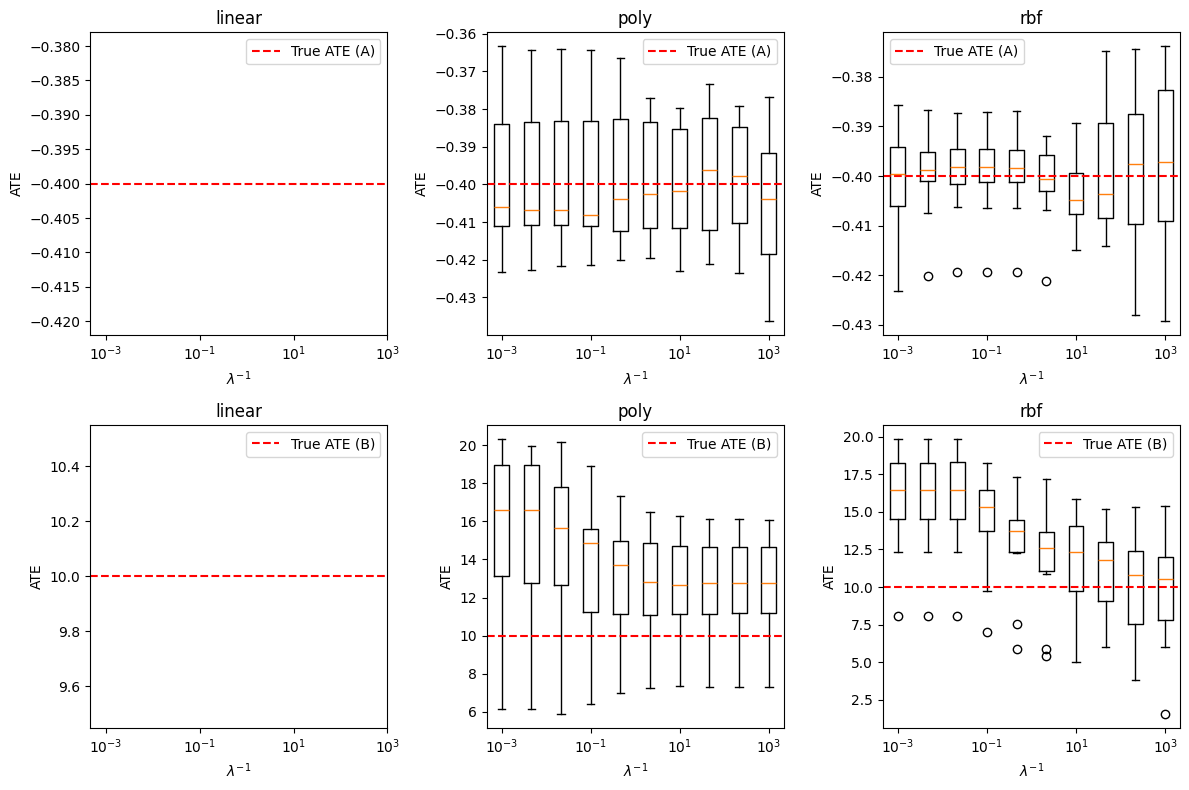

In [11]:
simulation_results = {**simulation_results_A, **simulation_results_B}
plot_ate(simulation_results_A, simulation_results_B)